<a href="https://colab.research.google.com/github/yohiharu/HolidayGame/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ニューラル画風変換

<table class="tfo-notebook-buttons" align="left">
  <td>
<img src="https://www.tensorflow.org/images/tf_logo_32px.png"><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer">TensorFlow.org で表示</a> </td>
  <td>
<img src="https://www.tensorflow.org/images/colab_logo_32px.png"><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/style_transfer.ipynb">Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/style_transfer.ipynb"><img src="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/style_transfer.ipynb">GitHub でソースを表示</a></td>
  <td>
<img src="https://www.tensorflow.org/images/download_logo_32px.png"><a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb">ノートブックをダウンロード</a> </td>
  <td>
<a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">	TF Hub モデルを参照</a> </td>
</table>

このチュートリアルでは、ディープラーニングを使用して、ある画像を別の画像の画風で作成します（ピカソやゴッホのように描いてみたいと思ったことはありませんか？）。これは*ニューラル画風変換*として知られるテクニックで、「<a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a>」（Gatys et al.）に説明されています。

注意: このチュートリアルでは、元の画風変換アルゴリズムを実演しています。画像のコンテンツを特定の画風に最適化するものです。最新のアプローチでは、画風が適用された画像を直接生成するようにモデルをトレーニングします（[CycleGAN](./cyclegan.ipynb) に類似）。このアプローチではより高速に実行することが可能です（最大 1000 倍）。

[TensorFlow Hub](https://tfhub.dev) から事前トレーニングされたモデルを使用した画風変換の簡単なアプリケーションについては、[任意の画像様式化モデル](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2)を使用する[任意のスタイルの高速画風変換](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)のチュートリアルをご覧ください。[TensorFlow Lite](https://www.tensorflow.org/lite) を使用した画風変換の例については、[TensorFlow Lite を使用した芸術的な画風変換](https://www.tensorflow.org/lite/examples/style_transfer/overview)を参照してください。

ニューラル画風変換は、*コンテンツ*画像と*画風参照*画像（有名な画家の作品など）という 2 つの画像をブレンドしてコンテンツ画像に見えるが、画風参照画像の画風で「描かれた」ように見える画像を出力するための最適化テクニックです。

これは、コンテンツ画像のコンテンツ統計と画風参照画像の画風統計に一致するように出力画像を最適化することで実装されています。これらの統計は、畳み込みネットワークを使用して画像から抽出されます。

たとえば、以下の犬の画像とワシリー・カジンスキーの作品 7 を使用しましょう。

 <img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" class="">

ウィキペディアコモンズの [Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)。作成者、[Elf](https://en.wikipedia.org/wiki/User:Elf)。ライセンス [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

 <img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg">

ガジンスキーがこの画風のみを使用してこの犬の絵を描こうとしたら、どのようになるのか見てみましょう。以下のようになるでしょうか？


<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;">        

## セットアップ


### モジュールのインポートと構成

In [1]:
!curl -o style.png https://m.media-amazon.com/images/I/91hZRSuOV7L._UF1000,1000_QL80_.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k  100  125k    0     0   962k      0 --:--:-- --:--:-- --:--:--  967k


In [2]:
!curl -o content.png https://www.decathlon.co.jp/cdn/shop/products/80f4987476f88ec9c12db2a3a71de473_700x.jpg?v=1686355714

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37905  100 37905    0     0   210k      0 --:--:-- --:--:-- --:--:--  210k


In [3]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

画像をダウンロードして、画風画像とコンテンツ画像を選択します。

In [6]:
content_path = "./content.png"
style_path = "./style.png"

## 入力を視覚化する

画像を読み込んで、その最大寸法を 512 ピクセルに制限する関数を定義します。

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

画像を表示する単純な関数を作成します。

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

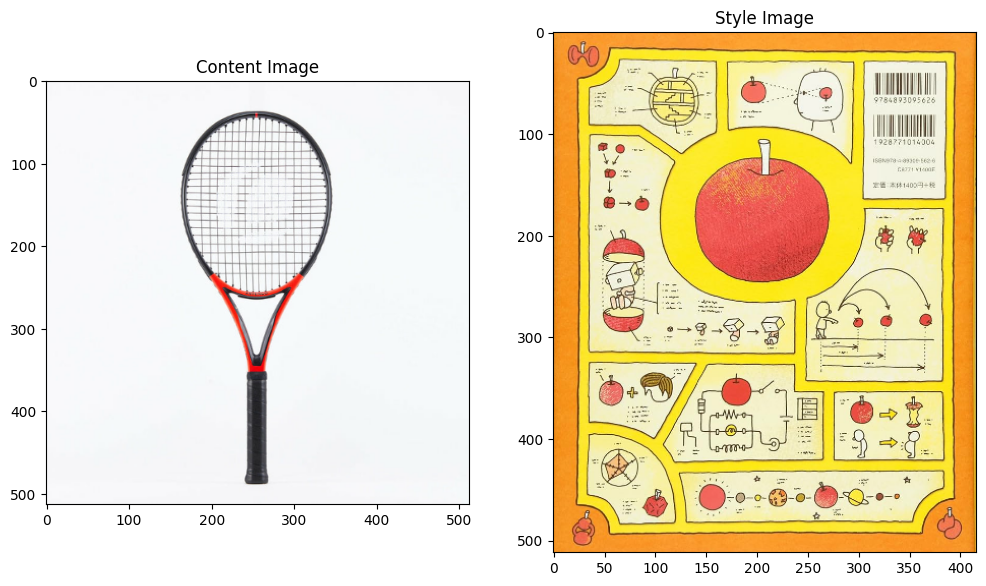

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub を使用した高速画風変換

このチュートリアルでは、画像コンテンツを特定の画風に最適化する、元の画風変換アルゴリズムを実演します。詳細に踏み込む前に、[TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) が何を行うのかを確認しましょう。

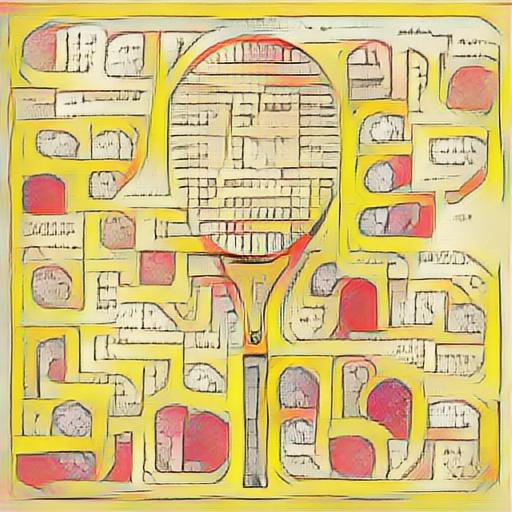

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## コンテンツと画風の表現を定義する

モデルの中間レイヤーを使用して、画像の*コンテンツ*と*画風*の表現を取得します。ネットワークの入力レイヤーから数えて最初のいくつかのレイヤーアクティベーションは、エッジやテクスチャといった低レベルの特徴を表します。ネットワークをさらに深く探ると、最後のいくつかのレイヤーは、*車輪*や*目*といった高レベルの特徴を表します。この場合、VGG19 ネットワークアーキテクチャという、事前トレーニング済みの画像分類ネットワークを使用しています。中間レイヤーは、画像からコンテンツと画風の表現を定義するために必要となるレイヤーです。入力画像については、これらの中間レイヤーにある、対応する画風とコンテンツターゲットの表現に一致するようにします。


[VGG19](https://keras.io/applications/#vgg19) を読み込んで、画像で実行し、正しく使用されていることを確認します。

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('racket', np.float32(0.99228024)),
 ('tennis_ball', np.float32(0.0076067992)),
 ('stethoscope', np.float32(2.1387687e-05)),
 ('strainer', np.float32(1.4992336e-05)),
 ('broom', np.float32(1.0039216e-05))]

分類ヘッドを除く `VGG19` を読み込み、レイヤー名をリストします。

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


画像の画風とコンテンツを表現する中間レイヤーをネットワークから選択します。


In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 画風とコンテンツ用の中間レイヤー

では、事前トレーニング済みの画像分類ネットワーク内のこれらの中間出力によって画風とコンテンツの表現を定義できるのはなぜでしょうか。

大まかに言えば、ネットワークが画像分類を行うには（このネットワークがトレーニングされた目的）、画像を理解している必要があります。これには、生の画像を入力ピクセルとして取り、生の画像ピクセルを、画像内に存在する特徴の複雑な理解への変換する内部表現が必要です。

これが、畳み込みニューラルネットワークがうまく一般化できる理由でもあります。不変性をキャプチャして、バックグラウンドノイズやその他の邪魔なものにとらわれない特徴をクラス内（猫と犬など）定義することができます。そのため、生の画像がモデルにフェードされる場所と出力分類ラベルの間のどこかで、モデルは複雑な特徴量抽出器としての役割を果たしていることになります。モデルの中間レイヤーにアクセスすることによって、入力画像のコンテンツと画風を説明することができます。

## モデルを構築する

`tf.keras.applications` のネットワークは、Keras の Functional API を使用して、中間レイヤーの値を簡単に抽出できるように設計されています。

Functional API を使用してモデルを定義するには、入力と出力を以下のように指定します。

`model = Model(inputs, outputs)`

以下の関数は、中間レイヤーの出力を返す VGG19 モデルを構築します。

In [14]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

モデルを作成するには、以下のように行います。

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 512, 416, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 512, 416, 64)
  min:  0.0
  max:  824.61194
  mean:  50.800186

block2_conv1
  shape:  (1, 256, 208, 128)
  min:  0.0
  max:  4051.4246
  mean:  253.21024

block3_conv1
  shape:  (1, 128, 104, 256)
  min:  0.0
  max:  9844.175
  mean:  304.12903

block4_conv1
  shape:  (1, 64, 52, 512)
  min:  0.0
  max:  22205.633
  mean:  1018.2832

block5_conv1
  shape:  (1, 32, 26, 512)
  min:  0.0
  max:  3954.3167
  mean:  77.10673



## 画風を計算する

画像のコンテンツは、中間特徴量マップの値によって表現されます。

これにより、画像の画風は、異なる特徴量マップの平均と相関によって表現できるようになります。各場所での特徴ベクトルの外積を取り、その外積をすべての場所で平均することにより、この情報を含むグラム行列を計算します。特定のレイヤーのグラム行列は以下のように計算できます。

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

これは、 `tf.linalg.einsum`関数を使用して簡潔に実装できます。

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 画風とコンテンツを抽出する


画風とコンテンツのテンソルを返すモデルを構築します。

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

画像に対して呼び出されると、このモデルは `style_layers` のグラム行列（画風）と `content_layers` のコンテンツを返します。

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  185466.84
    mean:  566.6104

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  290036.97
    mean:  16342.459

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  610382.56
    mean:  16133.92

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  8052906.0
    mean:  178603.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  71178.48
    mean:  1003.2112

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1510.7043
    mean:  8.666977


## 勾配下降法を実行する

この画風とコンテンツの抽出器を使用して、画風変換アルゴリズムを実装できるようになりました。各ターゲットに相対する画像の出力の平均二乗誤差を計算し、これらの損失の加重和を取って行います。

画風とコンテンツターゲット値を設定します。

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 512, 416, 3))
  warnings.warn(msg)


最適化する画像を含めて `tf.Variable` を定義します。これを素早く行うには、コンテンツ画像で初期化します（`tf.Variable` は、コンテンツ画像を同じ形状である必要があります）。

In [20]:
image = tf.Variable(style_image)

これはフローと画像であるため、ピクセル値を 0 から 1 に維持する関数を定義します。

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

オプティマイザを作成します。論文では、LBFGS が推奨されていますが、`Adam` も使用できます。

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

これを最適化するために、重みづけされた、2 つの損失の組み合わせを使用して合計損失を取得します。

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape` を使用して画像を更新します。

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    print(loss)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

いくつかのステップを実行してテストします。

In [26]:
shape = tf.shape(content_image)
image = tf.random.uniform(
    shape,
    minval=0.0,
    maxval=1.0,
    dtype=content_image.dtype
)

image = tf.Variable(
    image
)


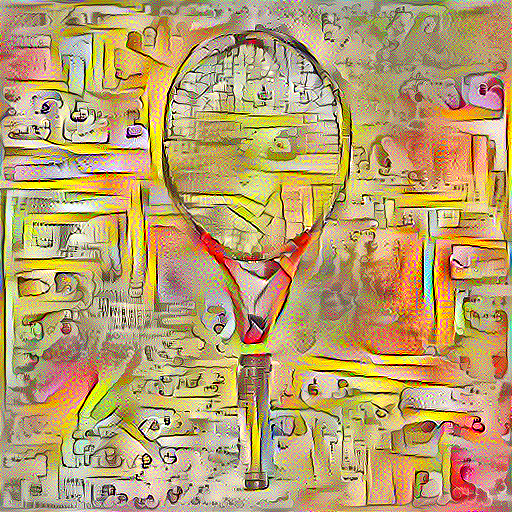

In [30]:
# @title デフォルトのタイトル テキスト
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

機能しているので、さらに長い最適化を実行します。

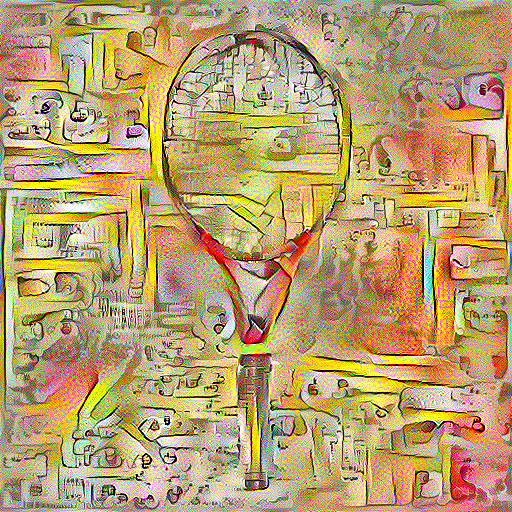

Train step: 1000
Total time: 92.8


In [29]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## 総変動損失

この基本実装には、 高周波アーチファクトが多く生成されるという難点があります。これらは、画像の高周波コンポーネントに明示的な正則化項を使用することで低下させることができます。画風変換では、通常これは*総変動損失*と呼ばれています。

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

これは、高周波コンポーネントがどのように高まったのかを示します。

また、この高周波コンポーネントは基本的にエッジ検出器でもあります。似たような出力は、Sobel エッジ検出器でも見られます。以下に例を示します。

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

これに伴う正則化損失は、値の二乗の和です。

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

何を行うかについては実演されましたが、これを自分で実装する必要はありません。TensorFlow には、標準実装が含まれています。

In [ ]:
tf.image.total_variation(image).numpy()

## 最適化を再実行する

`total_variation_loss` の重みを選択します。

In [ ]:
total_variation_weight=30

`train_step` 関数にそれを含めます。

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

イメージ変数とオプティマイザーを再初期化します。

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

そして、最適化を実行します。

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

最後に、結果を保存します。

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

## 詳細情報

このチュートリアルでは、元の画風変換アルゴリズムを紹介しました。画風変換の簡単なアプリケーションについては、この[チュートリアル](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)を参照してください。[TensorFlow Hub](https://tfhub.dev) から任意の画風変換モデルを使用する方法についての詳細が記載されています。